In [1]:
import numpy as np
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import random

## The SAM model trail (now in the other jupyter notebook file)

In [2]:
# from segment_anything import build_sam, SamPredictor 
# predictor = SamPredictor(build_sam(checkpoint='./sam_vit_h_4b8939.pth'))

In [7]:
def k_th_occurence(k, list_of_binary):
    """
    Find the kth occurence of 1 of a binary list
    """
    occurence = 0
    for i in range(len(list_of_binary)):
        if list_of_binary[i] == 1:
            occurence += 1
        if occurence == k:
            return i
    return 1/0  # Stop here, this is error if algo comes to this point

def get_list_of_centers(folder, img_name, output_dict, num_count_dict):
    # Read the image mask
    mask = cv2.imread(os.path.join(folder, img_name))
    # Find the connected component
    output = cv2.connectedComponentsWithStats(
	        mask[:, :, 0], 4)
    # Get them into structured outputs
    (numLabels, labels, stats, centroids) = output
    mask_binary = mask[:,:,0] > 122
    
    
    mask_mul_labels = mask_binary * (labels + 1) # Label + 1 is to make sure they all start from 1
    # Loop over the number of labels and check whether this is a background or foregroup
    for i in range(numLabels):
        num_pixel = np.sum(mask_mul_labels == (i+1))
        # print(num_pixel)
        # First identify background
        if num_pixel == 0:
            continue
        # First lets make sure that the centroid position is inside the current class
        # if labels[int(centroids[i, 0]), int(centroids[i, 1])] == i: # This means this is within current panel
        if labels[int(centroids[i, 1]), int(centroids[i, 0])] == i: # This means this is within current panel
            if img_name not in output_dict:
                output_dict[img_name] = []
            output_dict[img_name].append((int(centroids[i, 0]), int(centroids[i, 1])))
            num_count_dict['center'] += 1
        else: # We need to find the closest component within such component
            # print('Here is an instance of center NOT inside panel!')
            # print(img_name)
            # get the coordinate arrays
            l, w = np.shape(labels) # Get the size of the current image
            l_index = np.broadcast_to(np.arange(l), (w, l)).T
            w_index = np.broadcast_to(np.arange(w), (l, w))
            l_index_flat = np.reshape(l_index, [-1, 1])
            w_index_flat = np.reshape(w_index, [-1, 1])
            
            indicator_mask = mask_mul_labels == (i + 1)
            list_of_component = np.reshape(indicator_mask, [-1, 1])
            mid_point_index = k_th_occurence(num_pixel // 2, list_of_component)
            if img_name not in output_dict:
                output_dict[img_name] = []
            output_dict[img_name].append((int(w_index_flat[mid_point_index]), int(l_index_flat[mid_point_index])))
            assert indicator_mask[l_index_flat[mid_point_index], w_index_flat[mid_point_index]] == 1, 'in closest setting, x,y are possibly flipped'
            num_count_dict['midpoint'] += 1
            num_count_dict['set_of_non_concave_panel_imgs'].add(img_name)

def get_list_of_random_inside_points(folder, img_name, output_dict):
    # Read the image mask
    mask = cv2.imread(os.path.join(folder, img_name))
    # Find the connected component
    output = cv2.connectedComponentsWithStats(
	        mask[:, :, 0], 4)
    # Get them into structured outputs
    (numLabels, labels, stats, centroids) = output
    mask_binary = mask[:,:,0] > 122
    mask_mul_labels = mask_binary * (labels + 1) # Label + 1 is to make sure they all start from 1

    # get the coordinate arrays
    l, w = np.shape(labels) # Get the size of the current image
    l_index = np.broadcast_to(np.arange(l), (w, l)).T
    w_index = np.broadcast_to(np.arange(w), (l, w))
    l_index_flat = np.reshape(l_index, [-1, 1])
    w_index_flat = np.reshape(w_index, [-1, 1])
    
    # Loop over the number of labels and check whether this is a background or foregroup
    for i in range(numLabels):
        num_pixel = np.sum(mask_mul_labels == (i+1))
        # print(num_pixel)
        # First identify background
        if num_pixel == 0:
            continue
        # Directly choose an random point
        indicator_mask = mask_mul_labels == (i + 1)
        list_of_component = np.reshape(indicator_mask, [-1, 1])
        random_index = random.randint(1, num_pixel)
        mid_point_index = k_th_occurence(random_index, list_of_component)
        if img_name not in output_dict:
            output_dict[img_name] = []
        output_dict[img_name].append((int(w_index_flat[mid_point_index]), int(l_index_flat[mid_point_index])))
        assert indicator_mask[l_index_flat[mid_point_index], w_index_flat[mid_point_index]] == 1, 'in closest setting, x,y are possibly flipped'


## Solar PV task

In [7]:
img = cv2.imread('solar-pv/11ska655800_20_10.tif')
plt.imshow(img)

In [8]:
num_count_dict = {'center': 0, 'midpoint':0, 'set_of_non_concave_panel_imgs':set()}
output_dict = {}


# Run one test: Solar
# get_list_of_centers(folder='solar_masks',img_name='11ska655800_20_10.tif', 
                    # output_dict=output_dict, num_count_dict=num_count_dict )

# Run one test: Inria
# get_list_of_centers(folder='inria/train/gt',img_name='austin10.tif', 
#                     output_dict=output_dict, num_count_dict=num_count_dict )


# # Run all
folder = 'solar_masks'
# folder = 'inria/train/gt'
# for file in os.listdir(folder):
k, k_limit = 0, 9999999999
for file in tqdm(os.listdir(folder)):
    if '.tif' not in file:
        print('{} is not a .tif file, ignore')
        continue
    # Get the center point
    # get_list_of_centers(folder=folder,img_name=file, 
    #                 output_dict=output_dict, num_count_dict=num_count_dict)

    # Get a random point
    get_list_of_random_inside_points(folder=folder,img_name=file, 
                    output_dict=output_dict)
    
    k +=1 
    if k > k_limit:
        break

100%|██████████| 18302/18302 [24:40<00:00, 12.36it/s] 


In [7]:

mask = cv2.imread(os.path.join('inria/train/gt', 'austin10.tif'))

In [8]:
np.shape(mask)

(5000, 5000, 3)

In [11]:
output = cv2.connectedComponentsWithStats(
	        mask[:, :, 0], 4)

In [14]:
(numLabels, labels, stats, centroids) = output
mask_binary = mask[:,:,0] > 122

In [15]:
numLabels

926

In [9]:
####### RANDOM  point prompt #######
# Save the dictionary results down
with open('solar_pv_random_prompt_dict.pickle', 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [105]:
####### CENTER point prompt #######
# Save the dictionary results down
with open('solar_pv_center_prompt_dict.pickle', 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('solar_pv_center_prompt_output_record_dict.pickle', 'wb') as handle:
    pickle.dump(num_count_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('solar_pv_center_prompt_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [4]:
b['11ska625740_13_27.tif']

[(139, 203)]

In [89]:
img_name = '11ska625740_13_27.tif'
# Read the image mask
mask = cv2.imread(os.path.join(folder, img_name))
# Find the connected component
output = cv2.connectedComponentsWithStats(
        mask[:, :, 0], 4)
mask_binary = mask > 122
# Get them into structured outputs
(numLabels, labels, stats, centroids) = output

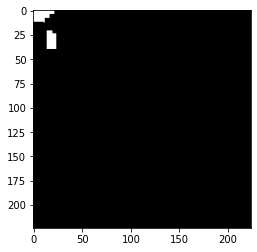

In [106]:
plt.imshow(mask)

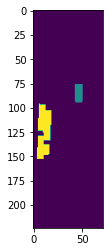

In [67]:
plt.imshow(labels)

In [46]:
print(np.shape(mask[:, :, 0]))
print(centroids)

(224, 72)
[[ 36.3851712  111.25465434]
 [ 46.5         84.88      ]
 [ 10.74675325 124.10064935]]


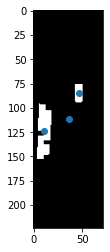

In [45]:
plt.imshow(mask)
plt.scatter(centroids[:, 0], centroids[:, 1])

## Inria_DG dataset

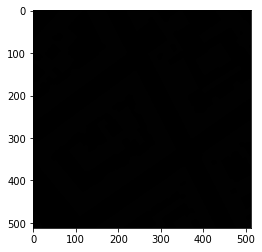

In [3]:
img = cv2.imread('Combined_Inria_DeepGlobe_650/patches/vienna17_y0x1994.png')
plt.imshow(img)

In [4]:
np.sum(img)

445959

In [5]:
np.shape(img)

(512, 512, 3)

In [6]:
np.mean(img[:, :, 0] == img[:, :, 1])

1.0

In [7]:
np.mean(img[:, :, 0])

0.5670661926269531

In [8]:
np.max(img)

1

In [9]:
np.min(img)

0